In [1]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma
from numpy import meshgrid
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry  import Point
from shapely.geometry import shape
import seaborn as sns


In [2]:
path_out_P = '/home/vikram/BCSD_data/' + 'US_P_BCSD/'
path_out_T = '/home/vikram/BCSD_data/' + 'US_T_BCSD/'

output_figname = ''#_eqm'

# init

In [3]:
gcm_names=['MIROC_ESM','CanESM2','HadGEM_AO','GFDL_CM3']
gcm_name  =  gcm_names[1]

In [4]:
def getclosest_ij(lats,lons,latpt,lonpt):
    dis_sq1=(lats-latpt)**2
    dis_sq2=(lons-lonpt)**2
    
    minidex_lat=dis_sq1.argmin()
    minidex_lon=dis_sq2.argmin()
    
    return minidex_lon,minidex_lat

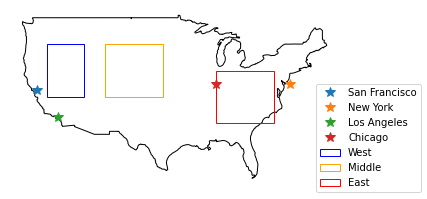

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import geopandas as gpd
from geopy.geocoders import Nominatim

colors= ['blue','orange','red','green','purple','brown','pink','gray','olive','cyan','k']


lats,lons = (np.arange(0,40,1),np.arange(-180,100,1))
XX12,YY12 = np.meshgrid(lons,lats)

fig, ax = plt.subplots()

for address in ['San Francisco','New York','Los Angeles', 'Chicago']:
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)
    [ind_lon,ind_lat] = getclosest_ij(lats,lons,location.latitude,location.longitude)
    plt.plot(lons[ind_lon],lats[ind_lat],marker='*',
             linestyle = 'none', markersize= 10,label =address)

ind = gpd.read_file('/home/vikram/BCSD_Shapefiles/Us_boundary.shp')
ind.plot(ax=ax,facecolor="none")

regional_boxes = [[-120,37,-113,45],
                  [-109,37,-98,45],
                  [-88,33,-77,41]]
regions = ['West', 'Middle' , 'East',]

for citer,co_ords in enumerate(regional_boxes):
    ax.add_patch(Polygon([(co_ords[0],co_ords[1]),
                           (co_ords[0],co_ords[3]),
                           (co_ords[2],co_ords[3]),
                           (co_ords[2],co_ords[1])],
                          facecolor='none',edgecolor= colors[citer],
                          label =regions[citer]))

plt.legend(bbox_to_anchor = (1.25, 0.6))

plt.axis('off')
plt.savefig("./plots/legend.svg", facecolor = 'w')


# Import data

In [7]:

metadata=np.load(path_out_P+ '/pre_metadata'+gcm_name+'.npy', allow_pickle=True)
st=metadata.item()['st']
en=metadata.item()['en']

mask_fine_obs=metadata.item()['mask']

lat_obs=metadata.item()['lat_obs']
lon_obs=metadata.item()['lon_obs']

N_random = 10
gcm_list = ['CanESM2','GFDL_CM3','MIROC_ESM','MRI_ESM1','ACCESS1_0','NorESM1_M','CM5A_LR','CNRM_CM5','MPI_ESM_MR']
N_esms = len(gcm_list)

tas_obs=np.load(path_out_T+ '/tas_obs.npy')
tas_data_all=np.empty([N_esms * 8,12*50,tas_obs.shape[1],tas_obs.shape[2]])
pre_obs=np.load(path_out_P+ '/pre_obs.npy')
pre_data_all=np.empty([N_esms * 8,12*50,pre_obs.shape[1],pre_obs.shape[2]])


# tas_data_all[0]=tas_obs
# pre_data_all[0]=pre_obs

for giter,gcm_name in tqdm(enumerate(gcm_list)):
    metadata=np.load(path_out_P+ '/pre_metadata'+gcm_name+'.npy', allow_pickle=True)
    
    lat_gcm=metadata.item()['lat_gcm']
    lon_gcm=metadata.item()['lon_gcm']
    
    tas_gcmh = np.load(path_out_T +'tas_gcm_'+gcm_name+ '.npy')
    tas_gcm = np.concatenate((tas_gcmh, 
                           np.load(path_out_T +'tas_gcm_future_'+gcm_name+ '.npy')),
                                   axis = 0)
    
    tas_gcm_fine=np.zeros((tas_gcm.shape[0],tas_obs.shape[1],tas_obs.shape[2]))

    for i in range(tas_gcm.shape[0]):
        tas_gcm_fine[i,:,:]=uu.regrid(tas_gcm[i,:,:],lat_gcm,lon_gcm,lat_obs,lon_obs)
        
    tas_gcm_fine_future = np.load(path_out_T+ '/detrended_BCSD_outputs_tas_'+gcm_name+ '_cru.npy')
    tas_data_all[giter]=tas_gcm_fine[:50*12,:,:]
    tas_data_all[giter +N_esms]= tas_gcm_fine[:50*12,:,:]
    tas_data_all[giter +N_esms * 2 ]=tas_gcm_fine_future[:50*12,:,:]
    tas_data_all[giter +N_esms * 3]= tas_gcm_fine_future[:50*12,:,:]
    
    tas_data_all[giter +N_esms * 4]=tas_gcm_fine[50*12:100*12,:,:]
    tas_data_all[giter +N_esms * 5]= tas_gcm_fine[150*12:,:,:]
    tas_data_all[giter +N_esms * 6 ]=tas_gcm_fine_future[50*12:100*12,:,:]
    tas_data_all[giter +N_esms * 7]= tas_gcm_fine_future[150*12:,:,:]
    
    
    pre_gcmh = np.load(path_out_P +'pre_gcm_'+gcm_name+ '.npy')
    pre_gcm = np.concatenate((pre_gcmh, 
                           np.load(path_out_P +'pre_gcm_future_'+gcm_name+ '.npy')),
                                   axis = 0)
    pre_gcm_fine=np.zeros((pre_gcm.shape[0],pre_obs.shape[1],pre_obs.shape[2]))
    lat_gcm=metadata.item()['lat_gcm']
    lon_gcm=metadata.item()['lon_gcm']
    
    for i in range(pre_gcm.shape[0]):
        pre_gcm_fine[i,:,:]=uu.regrid(pre_gcm[i,:,:],lat_gcm,lon_gcm,lat_obs,lon_obs)
    pre_gcm_fine_future = np.load(path_out_P+ '/detrended_BCSD_outputs_pre_'+gcm_name+'_cru.npy')
    
    
    pre_data_all[giter]=         pre_gcm_fine[:50*12,:,:]
    pre_data_all[giter +N_esms]= pre_gcm_fine[:50*12,:,:]
    pre_data_all[giter +N_esms * 2 ]=pre_gcm_fine_future[:50*12,:,:]
    pre_data_all[giter +N_esms * 3]= pre_gcm_fine_future[:50*12,:,:]
    
    pre_data_all[giter +N_esms * 4]=pre_gcm_fine[50*12:100*12,:,:]
    pre_data_all[giter +N_esms * 5]= pre_gcm_fine[150*12:,:,:]
    pre_data_all[giter +N_esms * 6 ]=pre_gcm_fine_future[50*12:100*12,:,:]
    pre_data_all[giter +N_esms * 7]= pre_gcm_fine_future[150*12:,:,:]
        


9it [00:38,  4.23s/it]


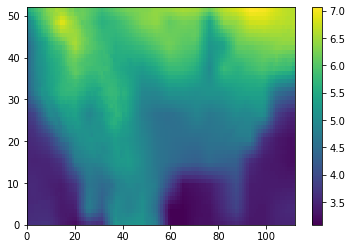

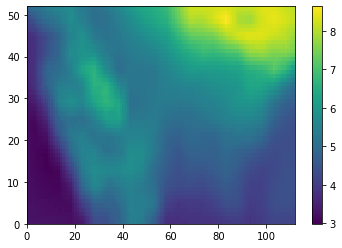

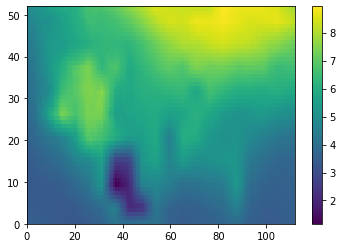

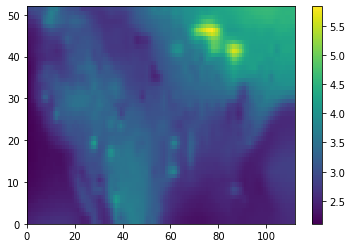

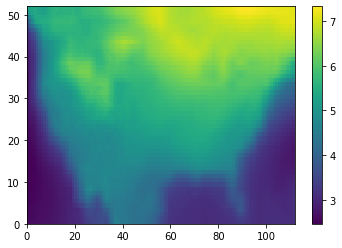

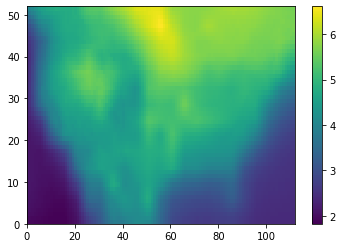

In [8]:
# giter = 0
# plt.figure()
# plt.pcolor(tas_data_all[giter +N_esms * 4].mean(axis=0) -tas_data_all[giter+N_esms*0].mean(axis=0))
# plt.colorbar()


# plt.figure()
# plt.pcolor(tas_data_all[giter +N_esms * 5].mean(axis=0) -tas_data_all[giter+N_esms*1].mean(axis=0))
# plt.colorbar()


# plt.figure()
# plt.pcolor(tas_data_all[giter +N_esms * 6].mean(axis=0) -tas_data_all[giter+N_esms*2].mean(axis=0))
# plt.colorbar()


plt.figure()
plt.pcolor(tas_data_all[0 +N_esms * 7].mean(axis=0) -tas_data_all[0+N_esms*3].mean(axis=0))
plt.colorbar()
plt.figure()
plt.pcolor(tas_data_all[1 +N_esms * 7].mean(axis=0) -tas_data_all[1+N_esms*3].mean(axis=0))
plt.colorbar()

plt.figure()
plt.pcolor(tas_data_all[2 +N_esms * 7].mean(axis=0) -tas_data_all[2+N_esms*3].mean(axis=0))
plt.colorbar()
plt.figure()
plt.pcolor(tas_data_all[3 +N_esms * 7].mean(axis=0) -tas_data_all[3+N_esms*3].mean(axis=0))
plt.colorbar()

plt.figure()
plt.pcolor(tas_data_all[4 +N_esms * 7].mean(axis=0) -tas_data_all[4+N_esms*3].mean(axis=0))
plt.colorbar()
plt.figure()
plt.pcolor(tas_data_all[5 +N_esms * 7].mean(axis=0) -tas_data_all[5+N_esms*3].mean(axis=0))
plt.colorbar()



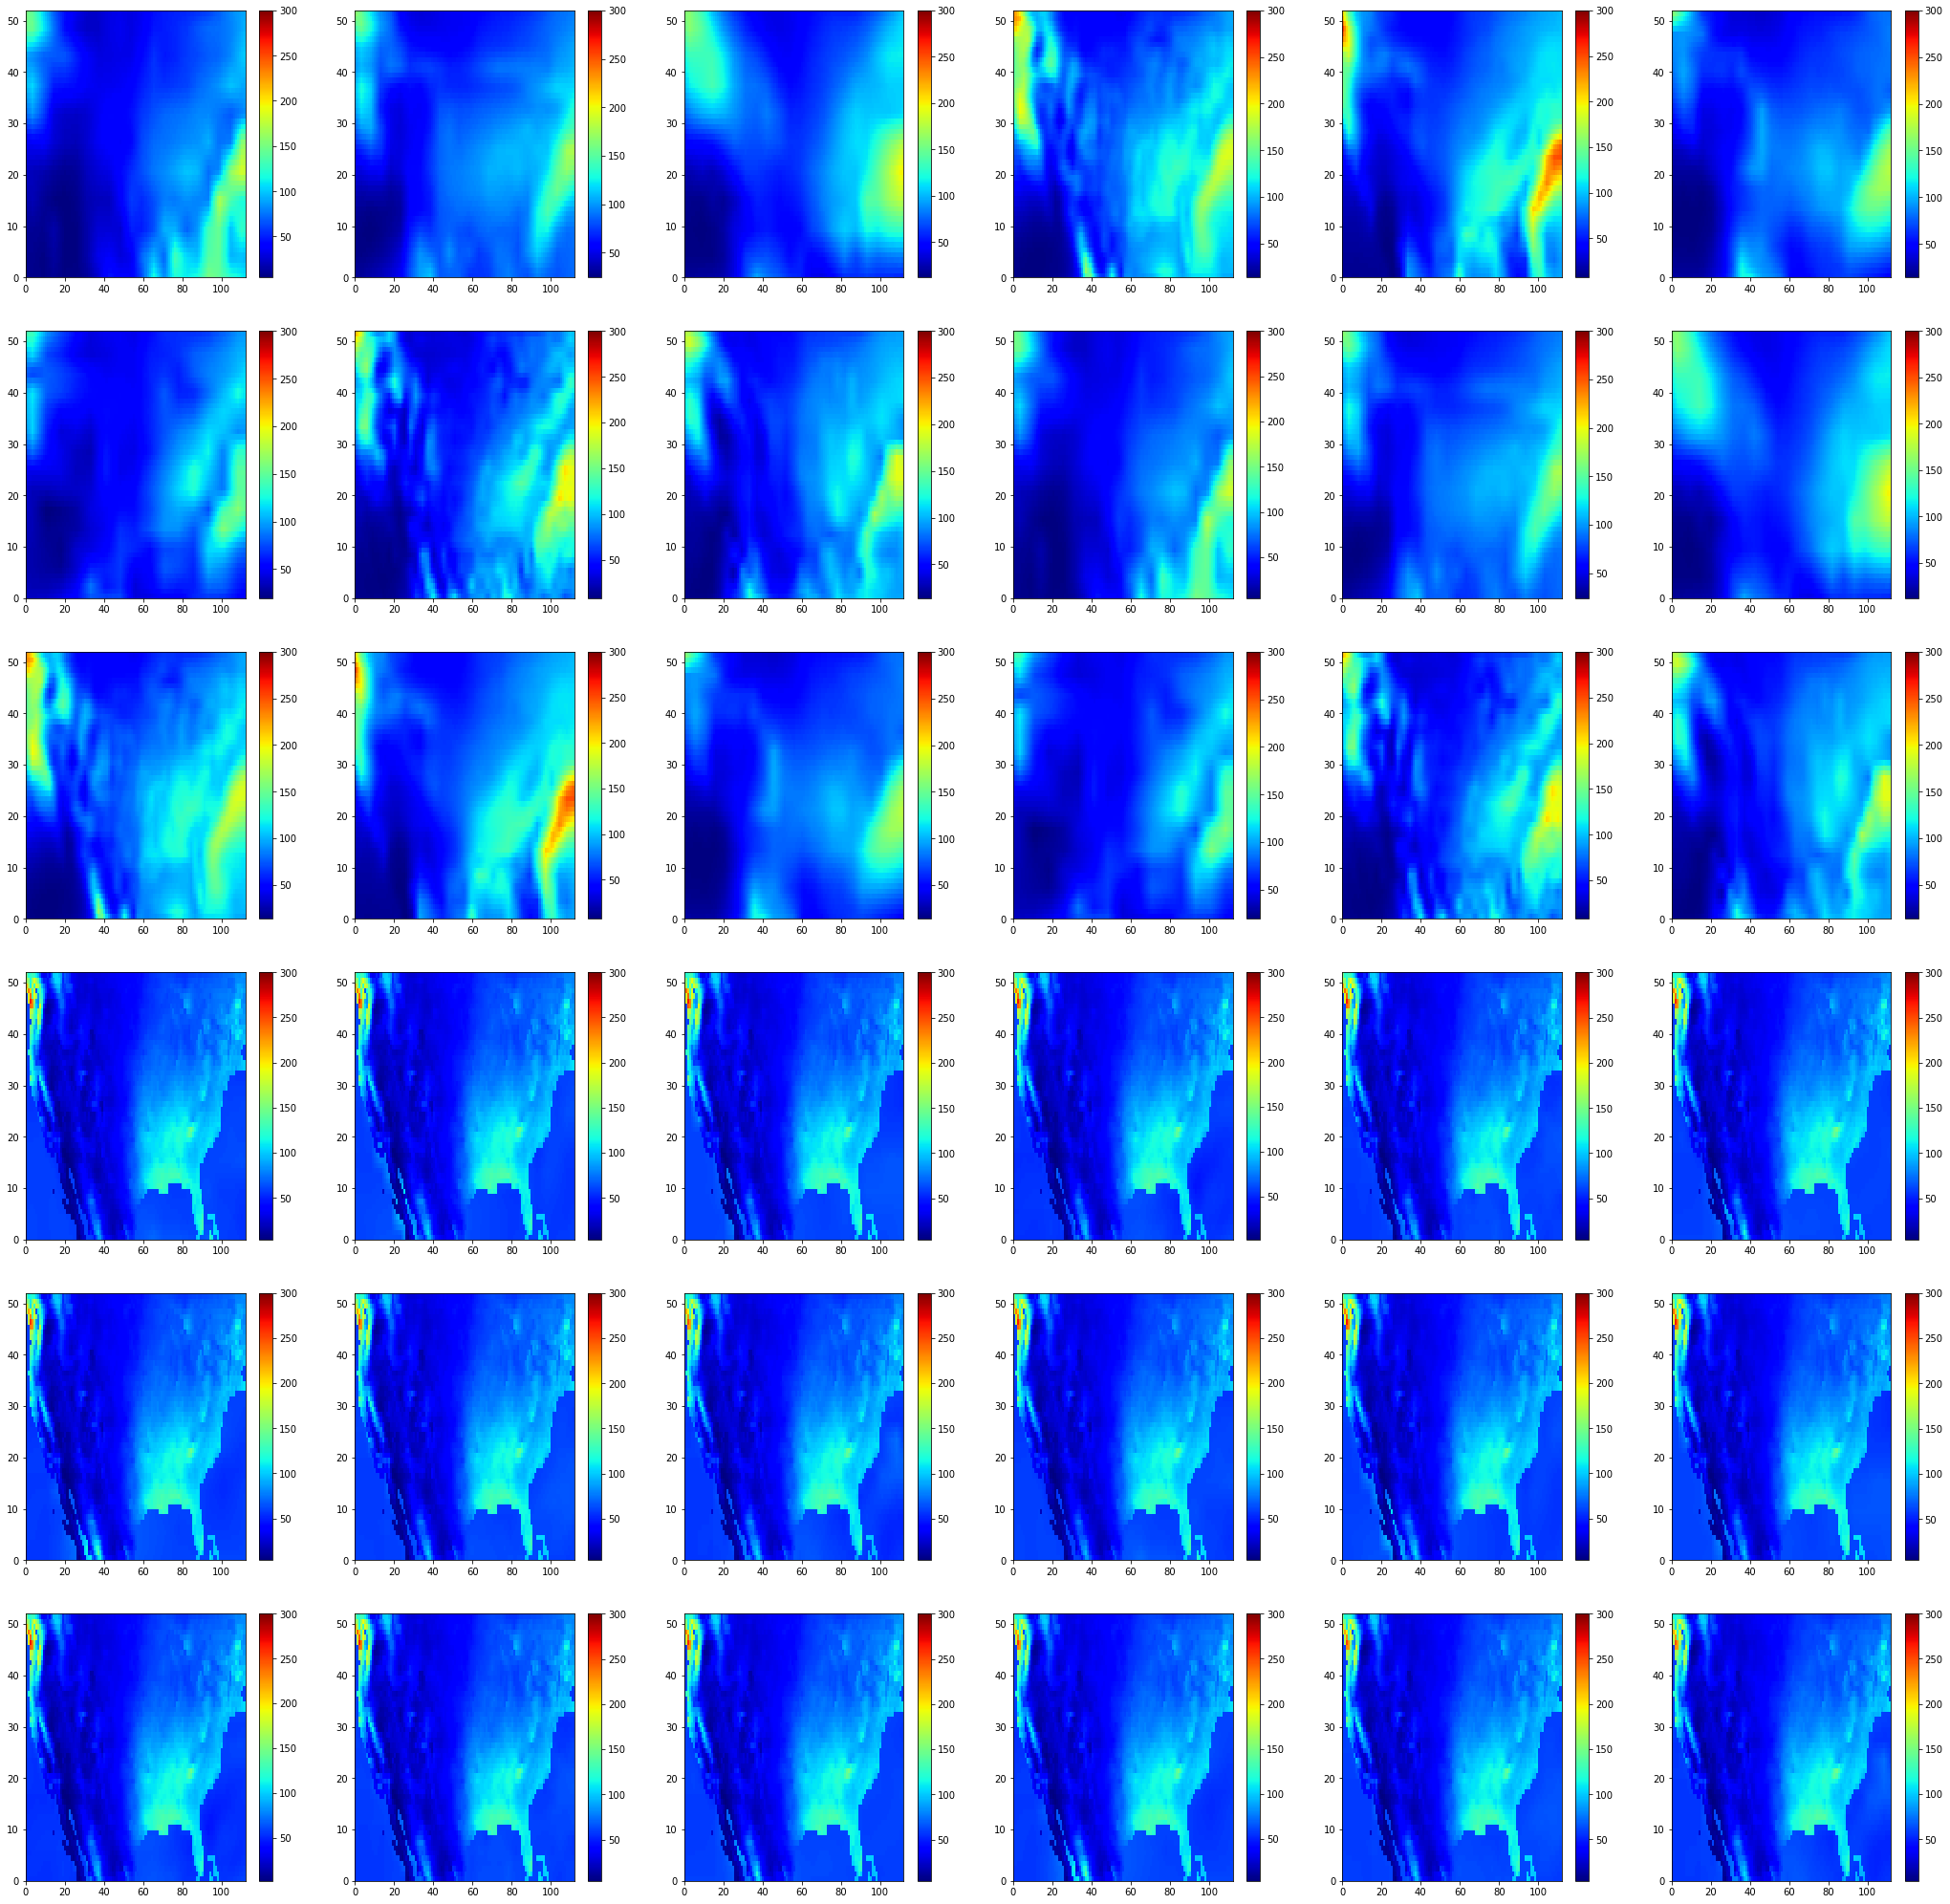

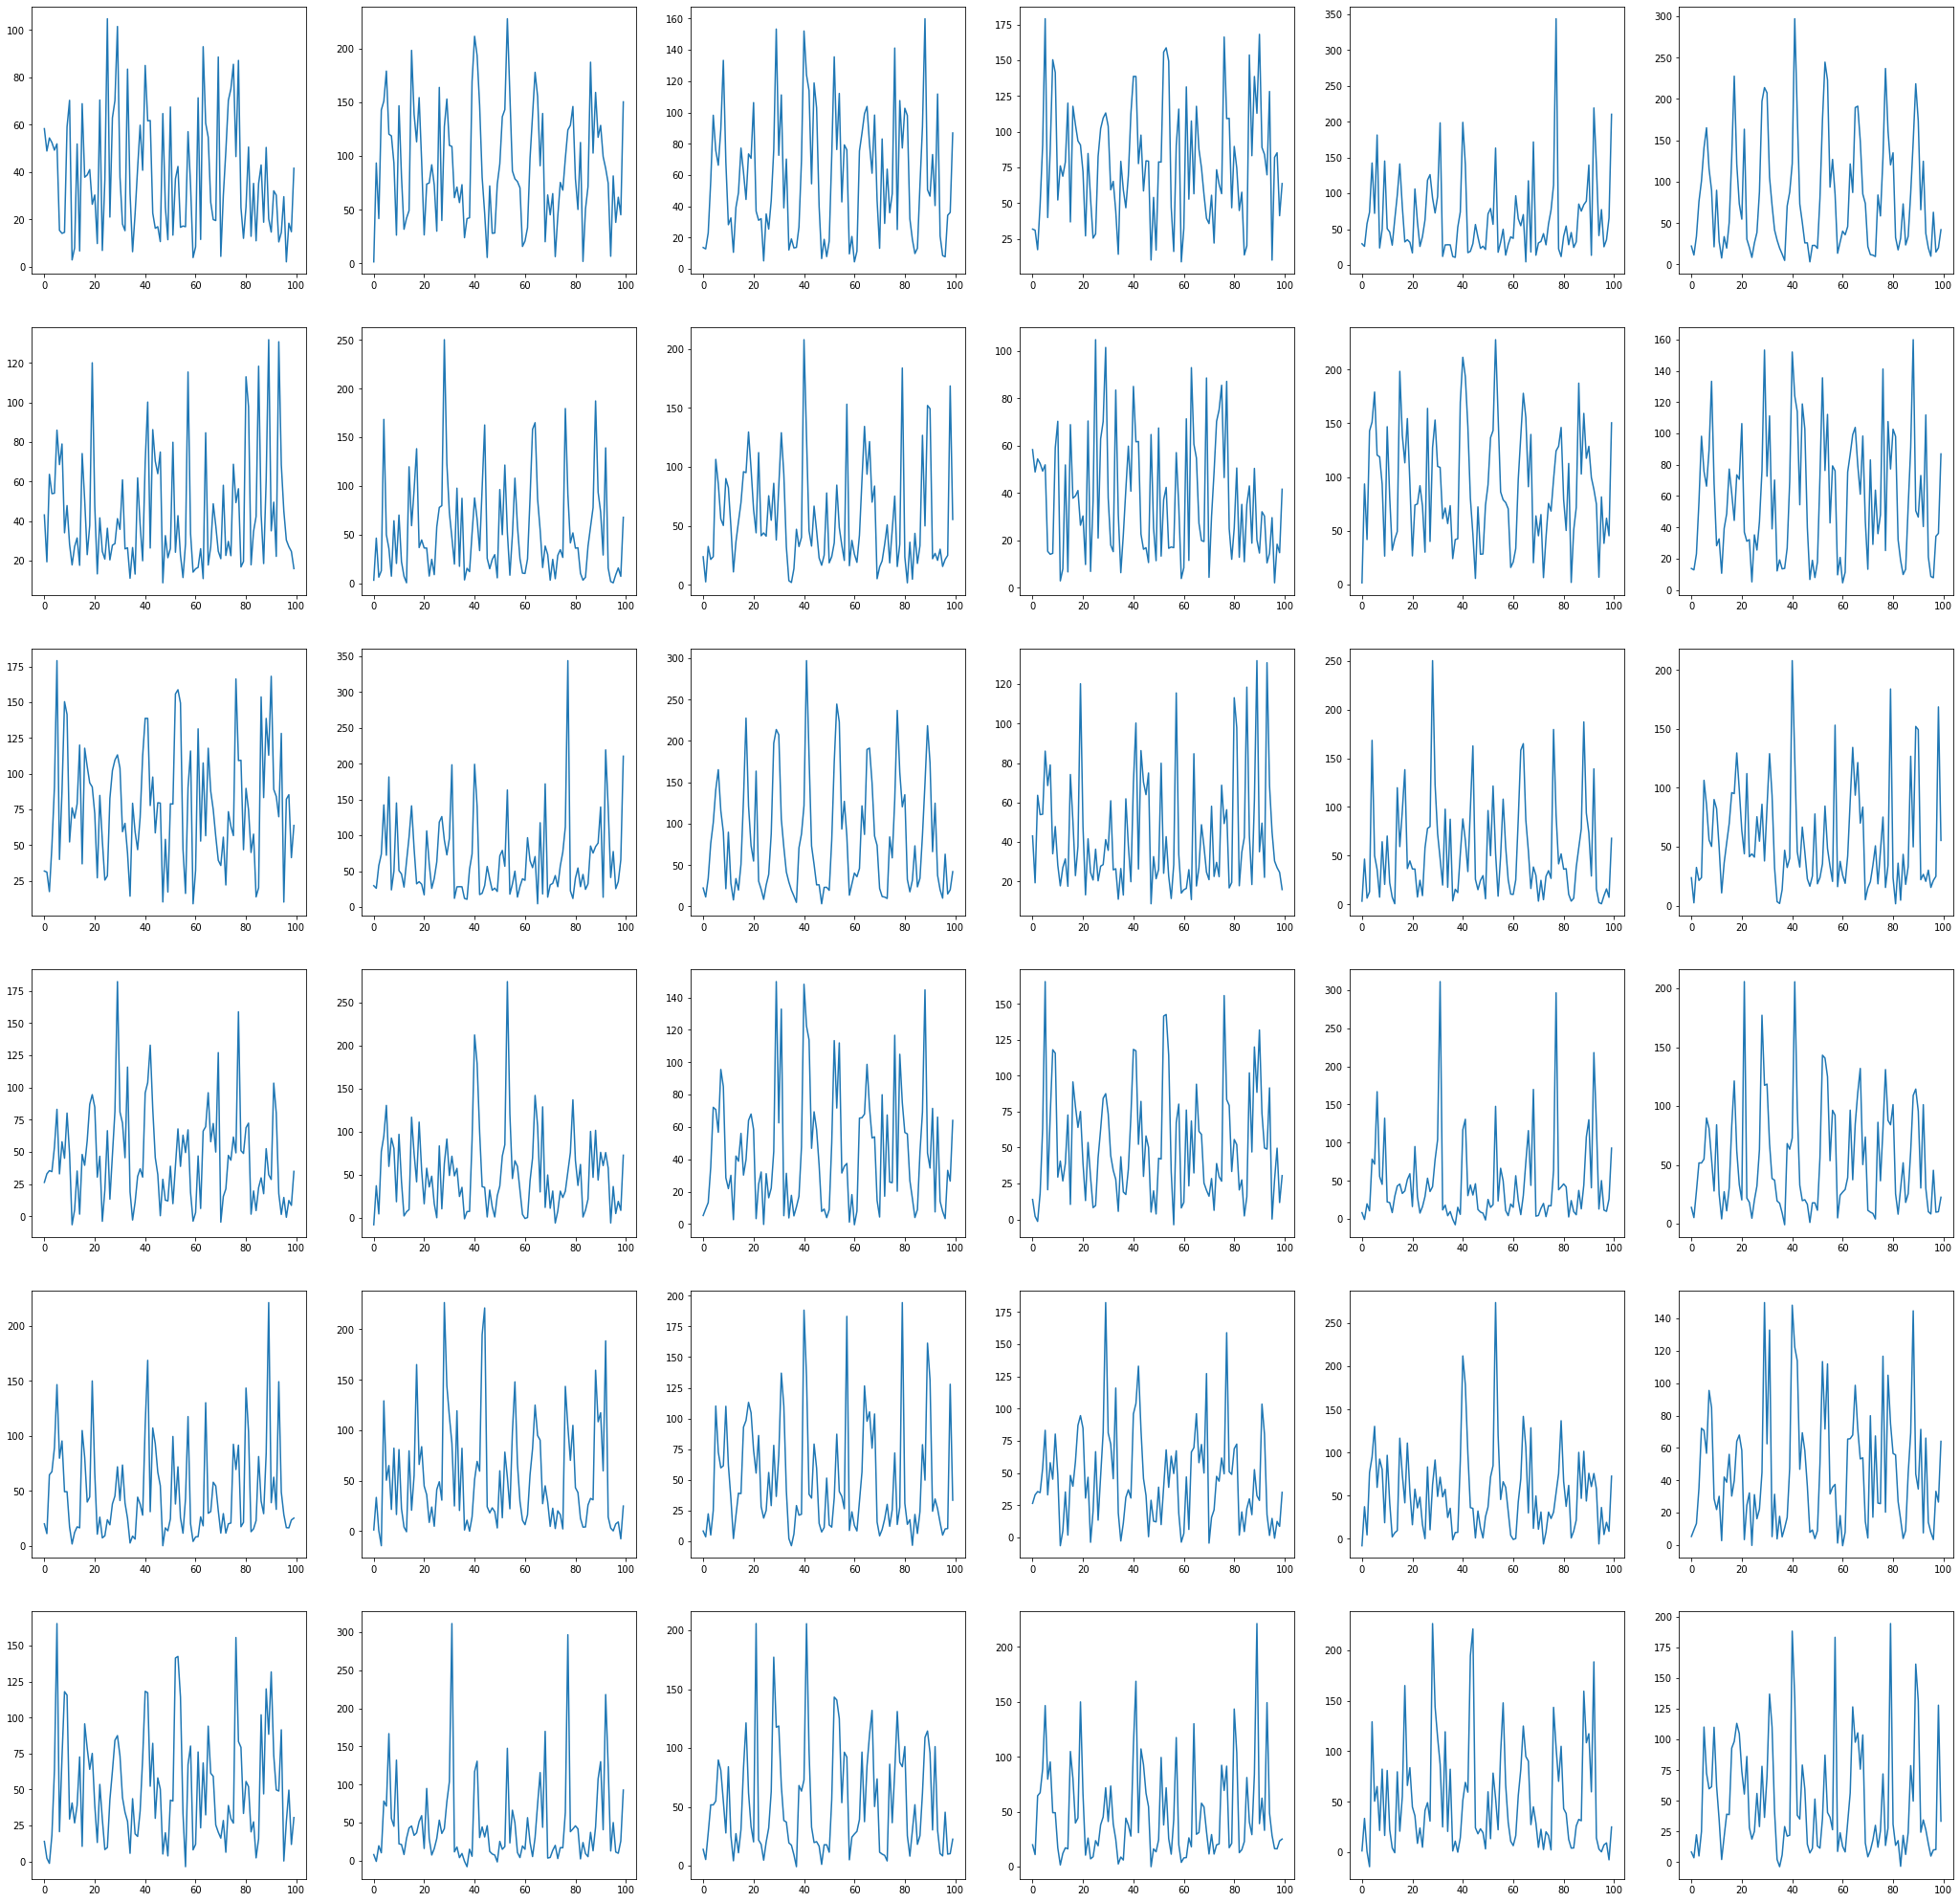

In [9]:
plt.figure(figsize =(36,36))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.pcolor(np.nanmean(pre_data_all[i],axis= 0),cmap='jet',vmax=300)
    plt.colorbar()
plt.figure(figsize =(36,36))
   
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.plot(pre_data_all[i][:100,25,52])
    


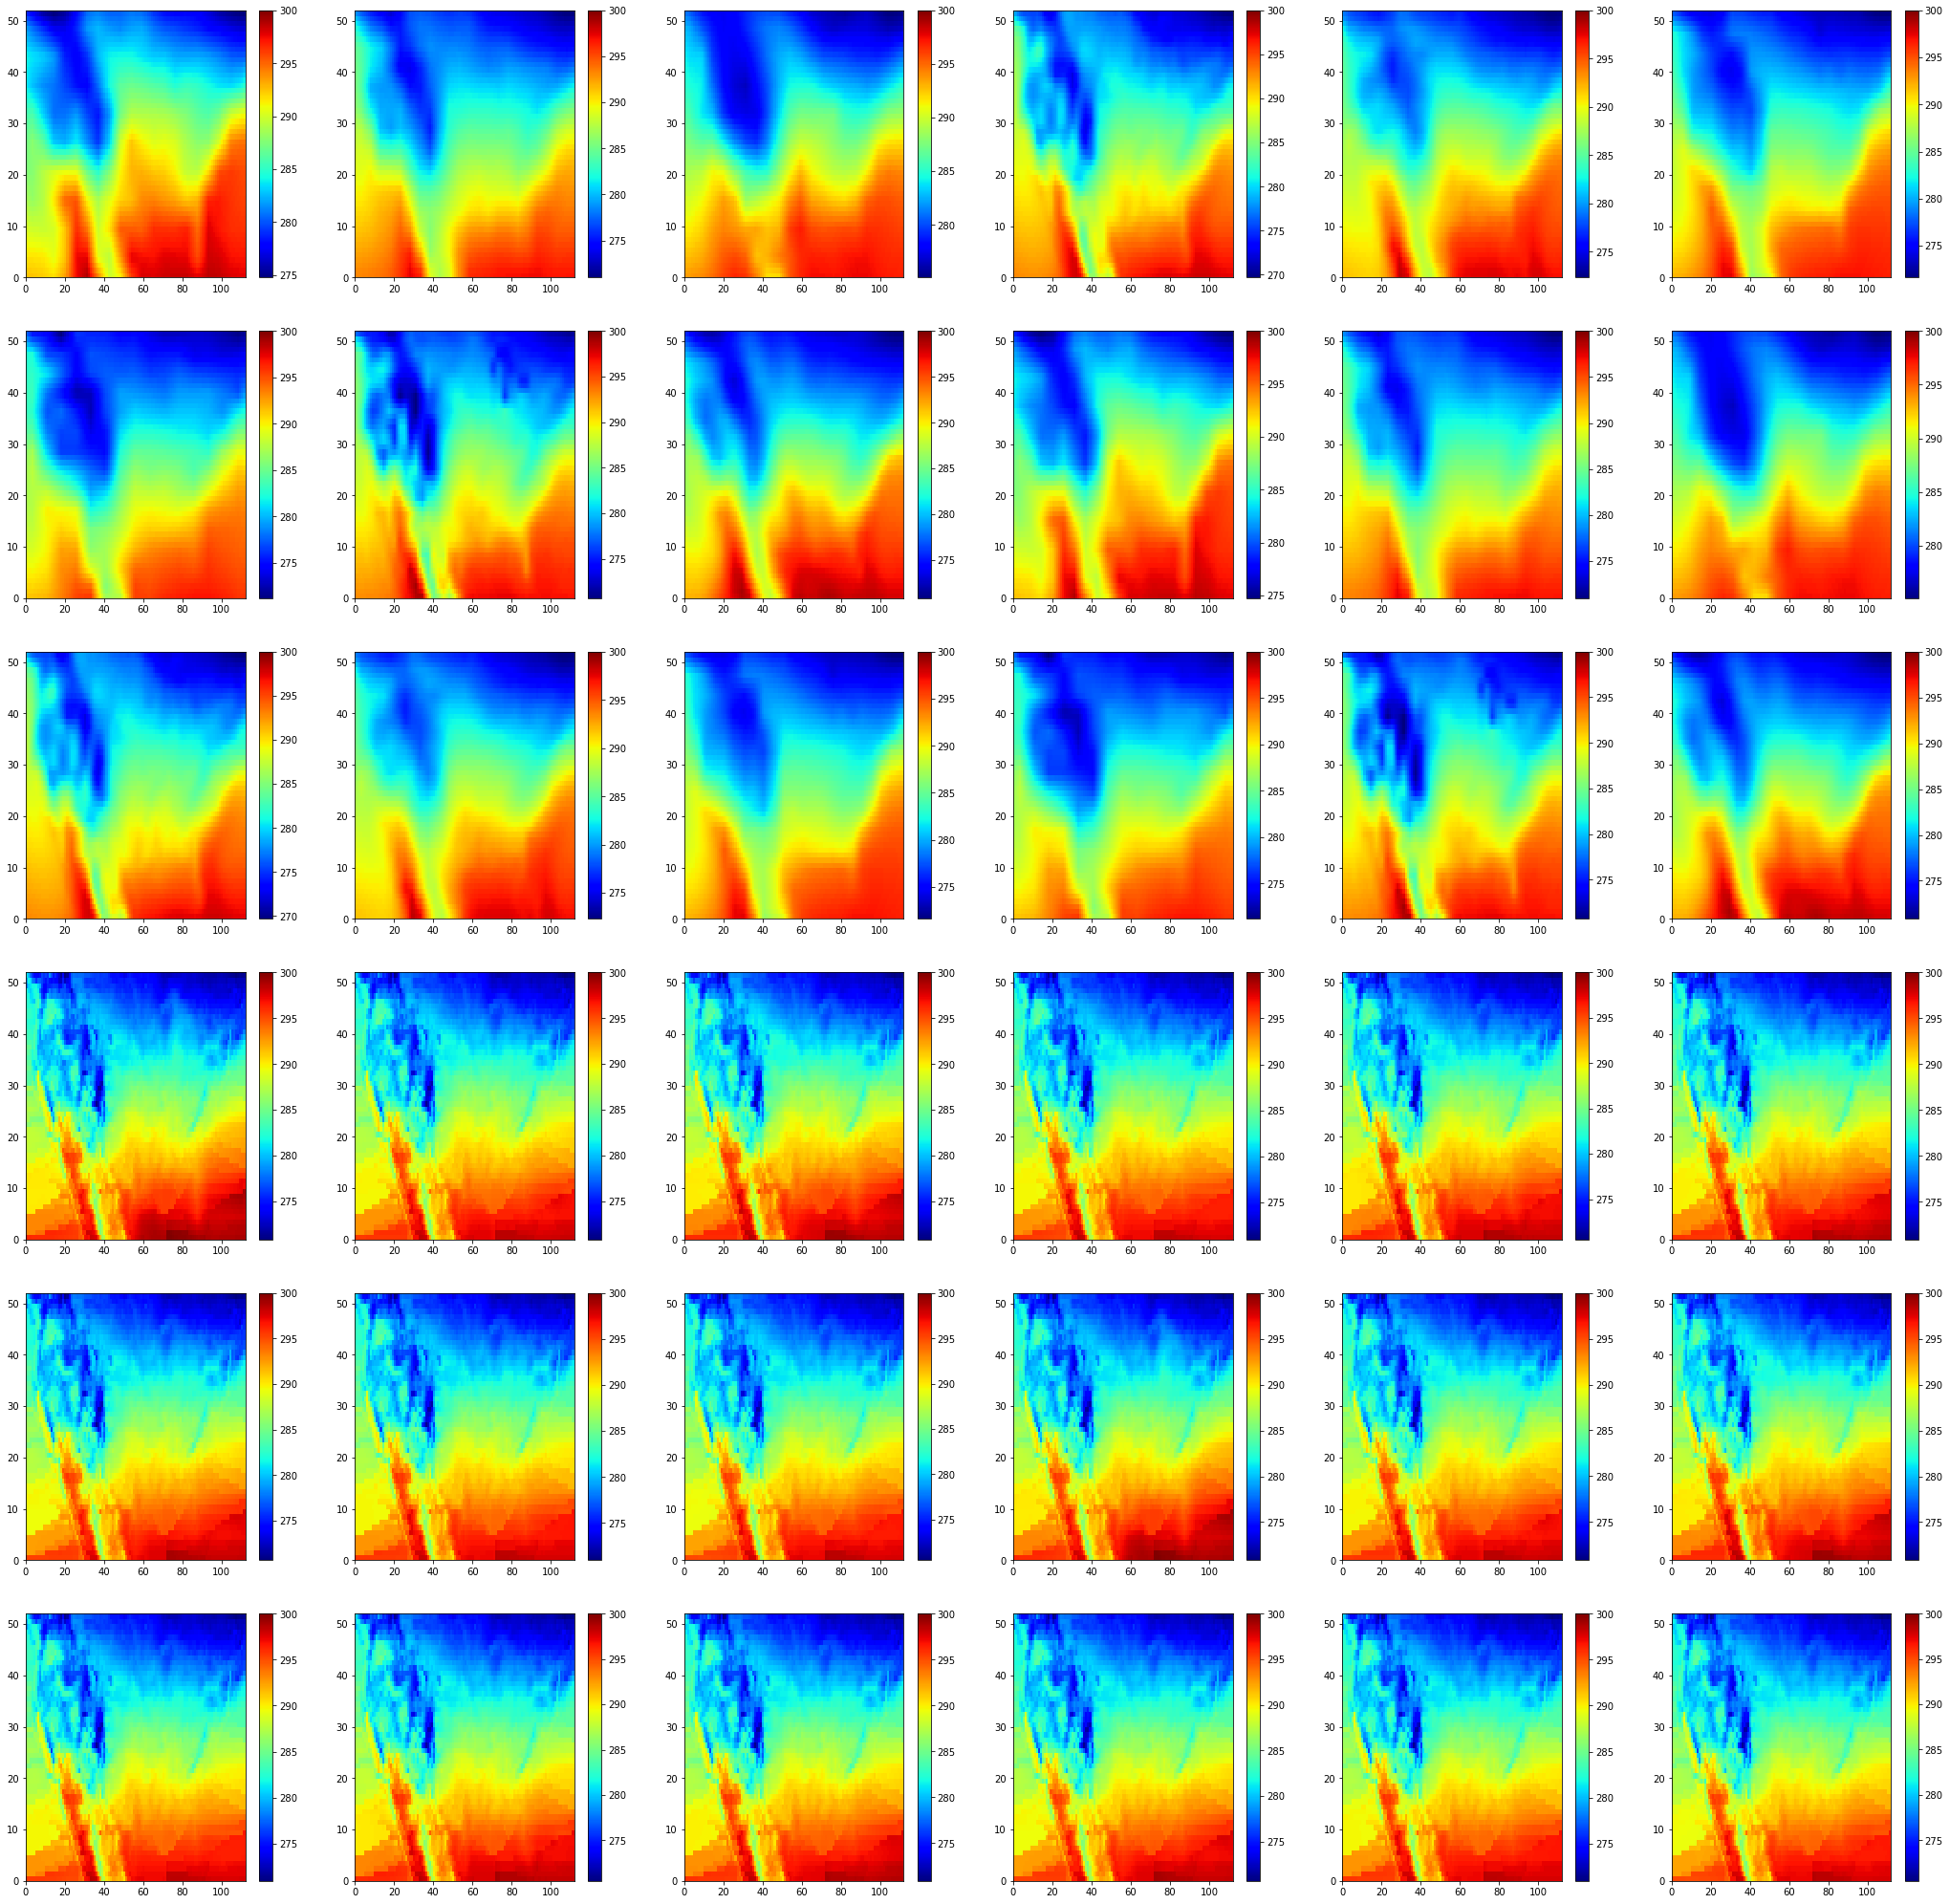

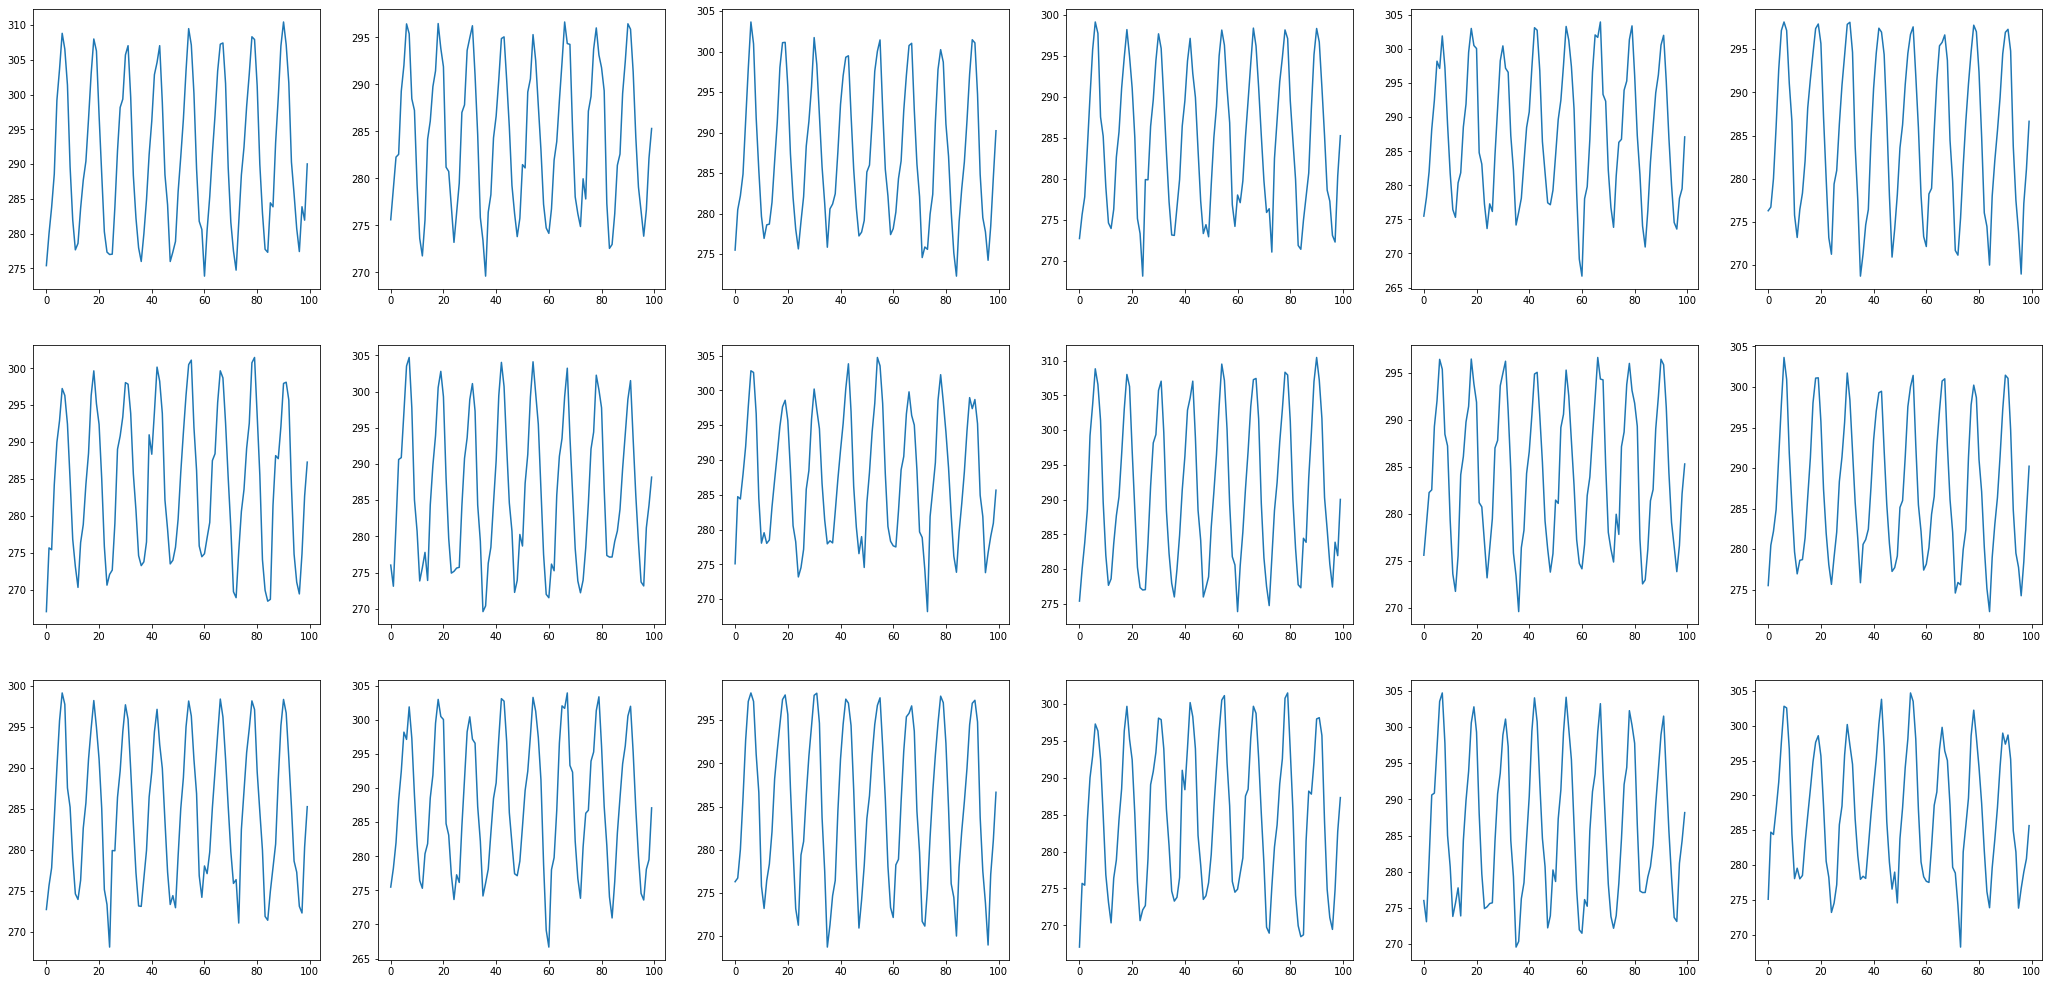

In [10]:
plt.figure(figsize =(36,36))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.pcolor(np.nanmean(tas_data_all[i],axis= 0),cmap='jet',vmax=300)
    plt.colorbar()
plt.figure(figsize =(36,36))
   
for i in range(18):
    plt.subplot(6,6,i+1)
    plt.plot(tas_data_all[i][:100,25,52])
    


# SPI

In [11]:
import scipy.stats

def calc_spi_nonparam(data):
  N=data.shape[0]
  index_ts=np.arange(N)  

  data_non_zeros=(data[data>0])
  index_non_zeros=index_ts[data>0]
  N_non_zeros=len(data_non_zeros)
  index_sorted=  np.argsort(data_non_zeros)
  ranks = np.empty_like(index_sorted)
  ranks[index_sorted] = np.arange(N_non_zeros)

  p_gringorten=(ranks-0.44)/(N_non_zeros+0.12)
  p_g_all=np.zeros_like(data)
  p_g_all[data>0]=p_gringorten


  count_zeros=(data[data==0].shape[0])
  count_total=(data.shape[0])
  p_zeros=count_zeros/count_total

  cdf2 = p_zeros + (1 - p_zeros) * p_g_all
  SPI= scipy.stats.norm.ppf(cdf2)
  return SPI



# def calc_spi_gamma(data_123,data_pred_123):
    
    
#     data_123 = data_123.reshape((12,-1),order ='F')
#     data_pred_123  =data_pred_123.reshape((12,-1),order ='F')
#     spi_pred = np.empty_like(data_pred_123)
#     for iter_m in range(12):
#         data=data_123[iter_m,:]
#         data_pred=data_pred_123[iter_m,:]
#         data_non_zeros=(data[data<1])
#         count_zeros=(data[data<1].shape[0])
#         count_total=(data.shape[0])
#         p_zeros=count_zeros/count_total

#         # print("Zeros,Total,p_zeros",count_zeros,count_total,p_zeros)

#         fita,fitloc,fitscale  = scipy.stats.gamma.fit(data_non_zeros,floc=0)

#         #   # print("Parameters: a,loc,scale:",fita,fitloc,fitscale)

#         #   aleph = np.ma.log(np.mean(data_non_zeros)) - np.log(data_non_zeros).mean(axis=0) 
#         #   alpha = (1. + np.sqrt(1.+4./3*aleph)) / (4.*aleph)
#         #   beta = np.mean(data_non_zeros)/alpha
#         #   print("alpha,beta",alpha,beta)
        
#         print(np.sum(np.isnan(cdf2)))
#         cdf2 = p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(data_pred, a=fita,loc=fitloc,scale=fitscale)
#         print(np.sum(np.isnan(cdf2)))
#         spi_pred[iter_m,:] =  scipy.stats.norm.ppf(cdf2)
    
    
#     SPI= spi_pred.flatten(order ='F') 
#     return SPI




    
def calc_spi_gamma(data_123,data_pred_123):
    
    nbins =10
    hist_tr = np.histogram(data_123, bins=nbins)
    hist_dist_tr = scipy.stats.rv_histogram(hist_tr)
    cdf2 = hist_dist_tr.cdf(data_pred_123)
    # print(cdf2)
    SPI =  scipy.stats.norm.ppf(cdf2)
    SPI[SPI<-3]=-3
    SPI[SPI>3]=3
    
    return SPI


In [12]:
def extract_regions(data_input,lat_obs,lon_obs):
    
    data_to_indices = []
    for address in ['San Francisco','New York','Los Angeles', 'Chicago']:
        geolocator = Nominatim(user_agent="Your_Name")
        location = geolocator.geocode(address)
        [ind_lon,ind_lat] = getclosest_ij(lat_obs.data,lon_obs.data,location.latitude%360,location.longitude%360)
        data_to_indices.append(data_input[:, ind_lat,ind_lon])


    regional_boxes = [[-120%360,45,-113%360,37],
                      [-109%360,45,-98%360,37],
                      [-88%360,41,-77%360,33]]
    
    
    for co_ords in regional_boxes:

        lat_index_123 = np.logical_and(lat_obs >= co_ords[3], lat_obs <= co_ords[1])
        lon_index_123 = np.logical_and(lon_obs >= co_ords[0], lon_obs <= co_ords[2])
        # print(lat_index_123.sum(), lon_index_123.sum())
        data_to_indices.append(np.nanmean(data_input[:, lat_index_123,:][:,:,lon_index_123],axis=(1,2)))

    data_to_indices.append(np.nanmean(data_input,axis=(1,2)))
    
    return data_to_indices


In [13]:
import copy
N_datasets = 36
N_regions = 8
N_esms = 9
dalta_tas_all = {}
delta_spi_all = {}
delta_tas_spi_all = {}

for diter in tqdm(range(N_datasets)):

    data_precipitation_all = extract_regions(pre_data_all[diter],lat_obs,lon_obs)
    
    data_temperature_all = extract_regions(tas_data_all[diter],lat_obs,lon_obs)
    
    data_precipitation_all_future = extract_regions(pre_data_all[diter+4*N_esms],lat_obs,lon_obs)
    data_temperature_all_future = extract_regions(tas_data_all[diter+4*N_esms],lat_obs,lon_obs)
    
    dalta_tas_all[diter] = []
    delta_spi_all[diter] = []
    delta_tas_spi_all[diter] = []
    


    for riter in range(N_regions):
        precipitation_data = data_precipitation_all[riter]
        temperature_data  = data_temperature_all[riter]
        precipitation_data[np.isnan(precipitation_data)] = 0
        
        precipitation_data_future = data_precipitation_all_future[riter]
        temperature_data_future  = data_temperature_all_future[riter]
        
#         plt.figure()
#         plt.plot(precipitation_data)
#         plt.figure()
#         plt.plot(temperature_data)
#         plt.figure()
#         plt.plot(precipitation_data_future)
#         plt.figure()
#         plt.plot(temperature_data_future)
        precipitation_data_future[np.isnan(precipitation_data_future)] = 0
        
        pre_6_monthly=copy.deepcopy(precipitation_data)
        pre_6_monthly[3:-2]  =   (precipitation_data[0:-5]+
                                  precipitation_data[1:-4]+
                                  precipitation_data[2:-3]+
                                  precipitation_data[3:-2]+
                                  precipitation_data[4:-1]+
                                  precipitation_data[5:])/6
        
        pre_6_monthly_future=copy.deepcopy(precipitation_data_future)
        pre_6_monthly_future[3:-2]  =   (precipitation_data_future[0:-5]+
                                  precipitation_data_future[1:-4]+
                                  precipitation_data_future[2:-3]+
                                  precipitation_data_future[3:-2]+
                                  precipitation_data_future[4:-1]+
                                  precipitation_data_future[5:])/6
#         print(precipitation_data)
#         print(precipitation_data_future)
        
#         print(np.max(SPI_monthly_np),np.min(SPI_monthly_np),)
#         print(np.max(SPI_monthly_np_future),np.min(SPI_monthly_np_future),)
#         print(np.max(precipitation_data_future),np.min(precipitation_data_future),)
#         print(np.max(precipitation_data),np.min(precipitation_data),)
#         print(np.max(temperature_data_future),np.min(temperature_data_future),)
#         print(np.max(temperature_data),np.min(temperature_data),)

        
        SPI_monthly_np=calc_spi_gamma(pre_6_monthly.flatten(),pre_6_monthly.flatten())
        SPI_monthly_np_future=calc_spi_gamma(pre_6_monthly.flatten(),pre_6_monthly_future.flatten())

        tp0=temperature_data
        tp1=temperature_data_future
        
        delta_tas = np.nanmean(tp1,axis=0)  -  np.nanmean(tp0,axis=0)
        # print(delta_tas)
        spi0=SPI_monthly_np
        spi1=SPI_monthly_np_future
        
        
        d__02=np.nansum(np.all(np.array([spi0<=-0.8]),axis=0))
        d__12=np.nansum(np.all(np.array([spi1<=-0.8]),axis=0))
        
        delta_spi_freq = (d__12)/(SPI_monthly_np.shape[0]/12)-(d__02)/(SPI_monthly_np_future.shape[0]/12)

        tas_d1_p0=np.nanmean(tp0[np.all(np.array([spi0<=-0.8]),axis=0)])
        tas_d1_p1=np.nanmean(tp1[np.all(np.array([spi1<=-0.8]),axis=0)])
        
        delta_tas_d1  =   tas_d1_p1    -  tas_d1_p0

        
        dalta_tas_all[diter].append(delta_tas)
        delta_spi_all[diter].append(delta_spi_freq)
        delta_tas_spi_all[diter].append(delta_tas_d1)


 83%|███████████████████████████████████▊       | 30/36 [05:52<01:00, 10.05s/it]/tmp/ipykernel_737483/4172833189.py:86: RuntimeWarning: Mean of empty slice
  tas_d1_p1=np.nanmean(tp1[np.all(np.array([spi1<=-0.8]),axis=0)])
100%|███████████████████████████████████████████| 36/36 [06:53<00:00, 11.49s/it]


In [14]:
import geopandas as gpd

gcm_name = "CanESM2"
lon_obs  = np.load("./data/lon_obs.npy" )
lat_obs  = np.load("./data/lat_obs.npy" )
mask_shape = np.load("./data/mask_shape.npy" , )
us_shp = gpd.read_file('/home/vikram/BCSD_Shapefiles/Us_boundary.shp')
title_x = [gcm_name, "BCSD-" + gcm_name, "$\delta$"]
title_y = ['Historical' ,'Historical' , 'Future' , 'Future',]
title_z = ["$\Delta$T" ] * 4 + [ "$\Delta$T|D"] *4 
data_to_indices_label = ['San Francisco','New York','Los Angeles', 'Chicago', 'West', 'Middle', 'East' ,"CONUS"]
markers=['o','^','s','p','P','*','h','+','x','X','D']
colors= ['blue','orange','red','green','purple','brown','pink','gray','olive','cyan','k']
N_esm =len(gcm_list)
N_random = 10
lxx, lyy = 0,1

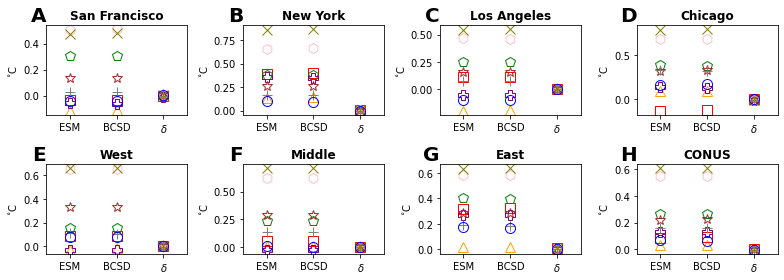

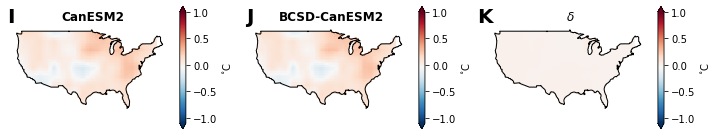

In [15]:
dapa = []
dapa.append(np.load("./data/data_ccs_" + str(0+1) + ".npy"))
dapa.append(np.load("./data/data_ccs_" + str(1+1) + ".npy"))
dapa.append(dapa[1]-dapa[0])

plt.figure(figsize = (11,4))
climit = [-1,1]
for pliter in range(8):
    ax = plt.subplot(2,4,pliter +1)
    for gi in range(N_esm):
        if gi == 0:
            zorder = 1
            # mfc = colors[gi]
        else:
            zorder = 0
        mfc = 'none'#colors[gi]

        plt.plot( 2 , dalta_tas_all[gi][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)

        plt.plot( 3 , dalta_tas_all[gi + N_esm * 2][pliter],
                 markers[gi],color = colors[gi], markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)
        
        plt.plot( 4 , dalta_tas_all[gi+N_esm * 2][pliter]- dalta_tas_all[gi][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)
    plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
    fontsize=20,color='k')
    plt.xticks(range(2,5),["ESM","BCSD","$\delta$"] )
    plt.title(data_to_indices_label[pliter],fontweight = 'bold')
    plt.xlim([1.5,4.5])
    # plt.ylim(climit)
    plt.ylabel("$^{\circ}$C")

plt.tight_layout()
# plt.savefig("./plots/delta_tas_simple_historical_part1.svg", facecolor = 'w')

plt.figure(figsize = (10,2))
for cc in range(3):
    iter1 = cc
    ax=plt.subplot(1,3,iter1+1)
    pcol = plt.pcolor( lon_obs-360,  lat_obs,
               ma.masked_array(dapa[iter1], mask=mask_shape),
               vmax = climit[0], 
               vmin = climit[1],
               cmap = "RdBu_r")
    plt.colorbar(extend = 'both',shrink=1,label = "$^{\circ}$C")
    plt.axis('off')
    us_shp.plot(ax=ax, fc = 'none')
    plt.title(title_x[cc],fontweight = 'bold' )
    plt.text(lxx, lyy, chr(65+8+cc), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
            fontsize=20,color='k')
    pcol.set_edgecolor('face')

plt.tight_layout()
# plt.savefig("./plots/delta_tas_simple_historical_part2.svg", facecolor = 'w')


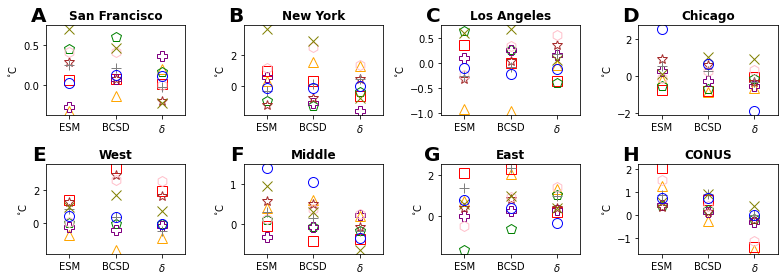

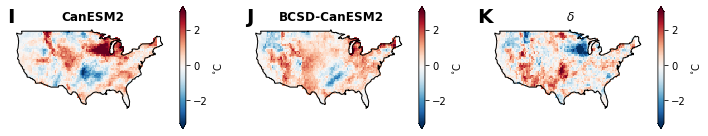

In [16]:

dapa = []
dapa.append(np.load("./data/data_ccs_" + str(4+1) + ".npy"))
dapa.append(np.load("./data/data_ccs_" + str(5+1) + ".npy"))
dapa.append(dapa[1]-dapa[0])

plt.figure(figsize = (11,4))
climit = [-3,3]

for pliter in range(8):
    ax = plt.subplot(2,4,pliter +1)
    for gi in range(N_esm):
        if gi == 0:
            zorder = 1
        else:
            zorder = 0
        mfc = 'none'
        plt.plot( 2 , delta_tas_spi_all[gi][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)

        plt.plot( 3 , delta_tas_spi_all[gi+N_esm * 2][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)
        
        plt.plot( 4 , delta_tas_spi_all[gi+N_esm * 2][pliter]- delta_tas_spi_all[gi][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)

    plt.xticks(range(2,5),["ESM","BCSD","$\delta$"] )
    plt.title(data_to_indices_label[pliter],fontweight = 'bold')
    # plt.ylim(climit)
    plt.xlim([1.5,4.5])
    plt.ylabel("$^{\circ}$C")
    plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
    fontsize=20,color='k')

plt.tight_layout()
# plt.savefig("./plots/delta_tas_complex_historical_part1.svg", facecolor = 'w')

plt.figure(figsize = (10,2))
for cc in range(3):
    iter1 = cc
    ax=plt.subplot(1,3,iter1+1)
    pcol = plt.pcolor( lon_obs-360,  lat_obs,
               ma.masked_array(dapa[iter1], mask=mask_shape),
               vmax = climit[0], 
               vmin = climit[1],
               cmap = "RdBu_r")
    plt.colorbar(extend = 'both',shrink=1,label ="$^{\circ}$C")
    plt.axis('off')
    us_shp.plot(ax=ax, fc = 'none')
    plt.title(title_x[cc] ,fontweight = 'bold')
    plt.text(lxx, lyy, chr(65+8+cc), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
            fontsize=20,color='k')
    pcol.set_edgecolor('face')
plt.tight_layout()
# plt.savefig("./plots/delta_tas_complex_historical_part2.svg", facecolor = 'w')


# plt.suptitle()|
# plt.savefig("./temp_plots/future_delta_tas_spi.png", dpi =150, facecolor = 'w')


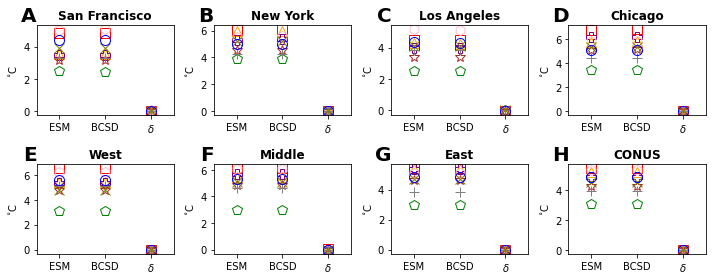

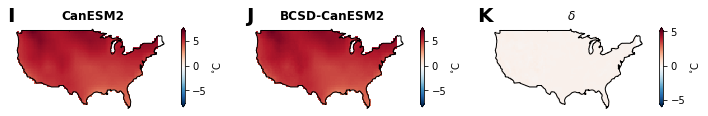

In [21]:

dapa = []
dapa.append(np.load("./data/data_ccs_" + str(2+1) + ".npy"))
dapa.append(np.load("./data/data_ccs_" + str(3+1) + ".npy"))
dapa.append(dapa[1]-dapa[0])

plt.figure(figsize = (10,4))
climit = [-7,7]

for pliter in range(8):
    ax = plt.subplot(2,4,pliter +1)
    for gi in range(N_esm):
        if gi == 0:
            zorder = 1
            # mfc = colors[gi]
        else:
            zorder = 0
        mfc = 'none'

        plt.plot( 2 , dalta_tas_all[gi + N_esms][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)

        plt.plot( 3 , dalta_tas_all[gi + N_esm * 3][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)
        
        plt.plot( 4 , dalta_tas_all[gi+N_esm * 3][pliter]- dalta_tas_all[gi +N_esms][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)


    plt.xticks(range(2,5),["ESM","BCSD","$\delta$"],rotation = 0 )
    plt.title(data_to_indices_label[pliter],fontweight = 'bold')
    # plt.ylim(climit)
    plt.xlim([1.5,4.5])
    plt.ylabel("$^{\circ}$C")
    plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
    fontsize=20,color='k')

    
plt.tight_layout()
# plt.savefig("./plots/delta_tas_simple_future_part1.svg", facecolor = 'w')

plt.figure(figsize = (10,2))
for cc in range(3):
    iter1 = cc
    ax=plt.subplot(1,3,iter1+1)
    if cc == 2:
        climit = [-5,5]
    pcol = plt.pcolor( lon_obs-360,  lat_obs,
               ma.masked_array(dapa[iter1], mask=mask_shape),
               vmax = climit[0], 
               vmin = climit[1],
               cmap = "RdBu_r",)
    plt.colorbar(extend = 'both',shrink=0.65,label = "$^{\circ}$C")
    pcol.set_edgecolor('face')
    plt.axis('off')
    us_shp.plot(ax=ax, fc = 'none')
    plt.title(title_x[cc] ,fontweight = 'bold')
    plt.text(lxx, lyy, chr(65+8+cc), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
            fontsize=20,color='k')
    
plt.tight_layout()
# plt.savefig("./plots/delta_tas_simple_future_part2.svg")

# plt.suptitle()|
# plt.savefig("./temp_plots/future_delta_tas.png", dpi =150, facecolor = 'w')


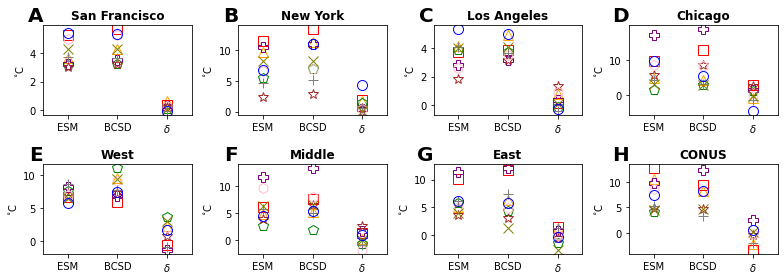

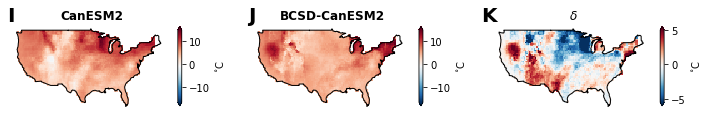

In [22]:

plt.figure(figsize = (11,4))
climit = [-15,15]
dapa = []
dapa.append(np.load("./data/data_ccs_" + str(6+1) + ".npy"))
dapa.append(np.load("./data/data_ccs_" + str(7+1) + ".npy"))
dapa.append(dapa[1]-dapa[0])

for pliter in range(8):
    ax = plt.subplot(2,4,pliter +1)
    for gi in range(N_esm):
        if gi == 0:
            zorder = 1
        else:
            zorder = 0
        mfc = 'none'

        plt.plot( 2 , delta_tas_spi_all[gi + N_esms][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)

        plt.plot( 3 , delta_tas_spi_all[gi + N_esm * 3][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)
        
        plt.plot( 4 , delta_tas_spi_all[gi+N_esm * 3][pliter]- delta_tas_spi_all[gi +N_esms][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc=mfc,label = gcm_list[gi],zorder =zorder)

    plt.xticks(range(2,5),["ESM","BCSD","$\delta$"],rotation = 0 )
    plt.title(data_to_indices_label[pliter],fontweight = 'bold')
    
    plt.xlim([1.5,4.5])
    plt.ylabel("$^{\circ}$C")

    plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
    fontsize=20,color='k')


plt.tight_layout()
# plt.savefig("./plots/delta_tas_complex_future_part1.svg", facecolor = 'w')

plt.figure(figsize = (10,2))

        
for cc in range(3):
    iter1 = cc
    ax=plt.subplot(1,3, iter1+1)
    if cc == 2:
        climit = [-5,5]

    pcol = plt.pcolor( lon_obs-360,  lat_obs,
               ma.masked_array(dapa[iter1], mask=mask_shape),
               vmax = climit[0], 
               vmin = climit[1],
               cmap = "RdBu_r")
    plt.colorbar(extend = 'both',shrink=0.65,label = "$^{\circ}$C")
    plt.axis('off')
    us_shp.plot(ax=ax, fc = 'none')
    plt.title(title_x[cc] ,fontweight = 'bold')

    plt.text(lxx, lyy, chr(65+8+cc), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
            fontsize=20,color='k')
    pcol.set_edgecolor('face')

plt.tight_layout()
# plt.suptitle()|
# plt.savefig("./temp_plots/future_delta_tas.png", dpi =150, facecolor = 'w')
plt.savefig("./plots/delta_tas_complex_future_part2.svg", facecolor = 'w')


# Other

In [44]:
dapa = []
for diter in range(8):
    dapa.append(np.load("./data/data_ccs_" + str(diter+1) + ".npy"))

lon_obs  = np.load("./data/lon_obs.npy" )
lat_obs  = np.load("./data/lat_obs.npy" )
mask_shape = np.load("./data/mask_shape.npy" , )
import geopandas as gpd
us_shp = gpd.read_file('/home/vikram/BCSD_Shapefiles/Us_boundary.shp')

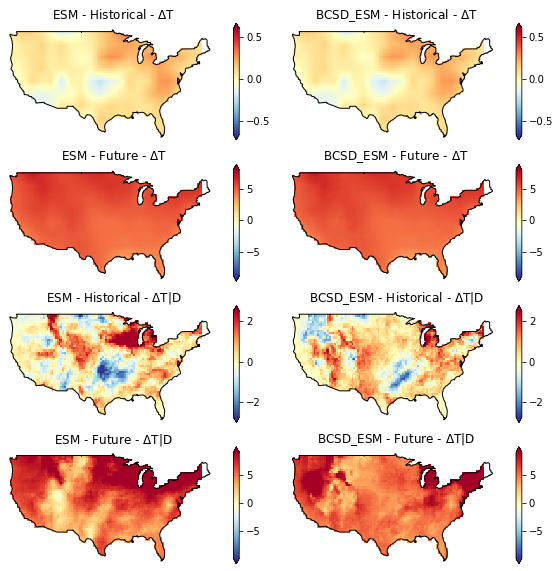

In [45]:
plt.figure(figsize = (8,8))


climits = [
           [-0.6,0.6],
           [-8,8],
           [-2.5,2.5],
           [-9,9]
          ]

title_x = ["ESM", "BCSD_ESM", "$\delta$"]
title_y = ['Historical' ,'Historical' , 'Future' , 'Future',]
title_z = ["$\Delta$T" ] * 4 + [ "$\Delta$T|D"] *4 

for rr in range(2):
    for cc in range(4):
        iter1 = cc + rr * 4
        ax=plt.subplot(4,2,iter1+1)
        plt.pcolor( lon_obs-360,  lat_obs,
                   ma.masked_array(dapa[iter1], mask=mask_shape),
                   vmax = climits[iter1//2][0], 
                   vmin = climits[iter1//2][1],
                   cmap = "RdYlBu_r")
        plt.colorbar(extend = 'both')
        plt.axis('off')
        us_shp.plot(ax=ax, fc = 'none')
        plt.title(title_x[iter1%2] + " - " + title_y[iter1%4] + ' - ' + title_z[iter1])
plt.tight_layout()

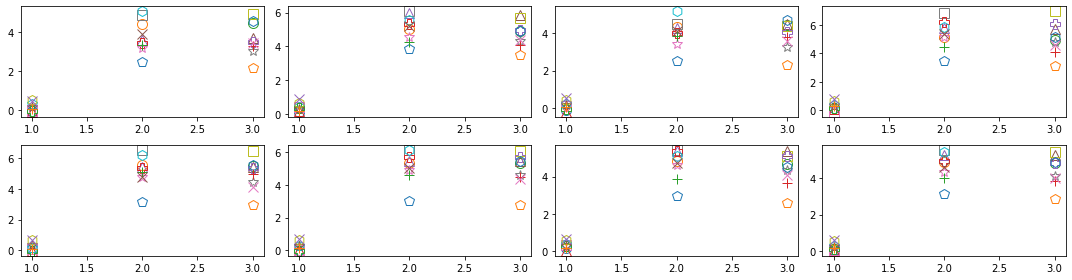

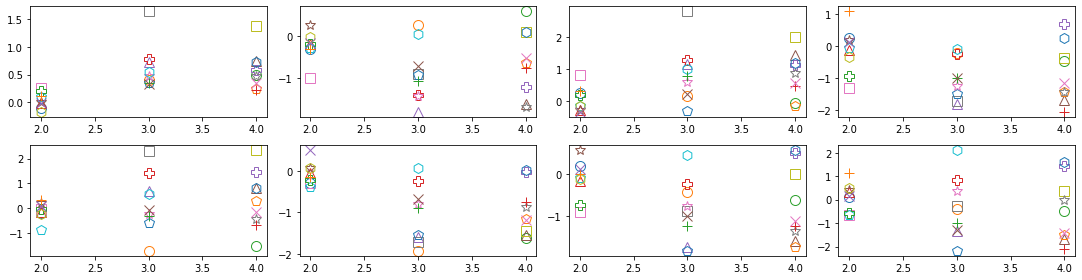

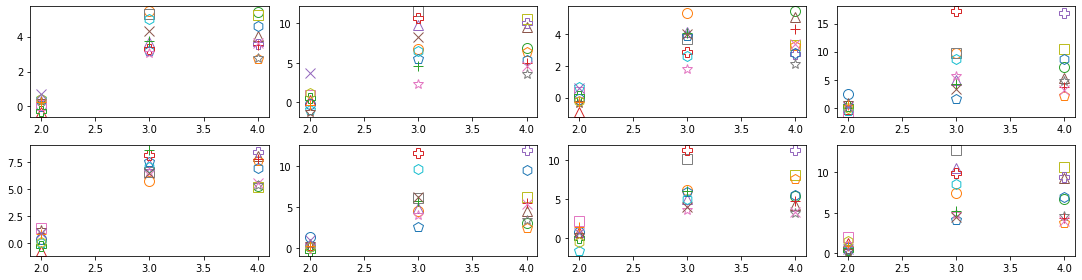

In [38]:
N_esm =len(gcm_list)

markers=['o','^','s','p','P','*','h','+','x','X','D']


# data_to_indices_label  =  ['Kolkata', 'Mumbai', 'New Delhi' , 'Chennai' , 
#                            'Western India', 'Central India' , 'NE India','All India']

# plt.plot( 0,0, 'D',markersize = 10,color ='w',linestyle = 'None',mfc='none',label ='Random Fields')
plt.figure(figsize = (15,4))

for pliter in range(8):
    plt.subplot(2,4,pliter +1)
    for gi in range(N_esm):
        plt.plot( 1 , dalta_tas_all[gi][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 2 , dalta_tas_all[gi+N_esm][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
        
        plt.plot( 3 , dalta_tas_all[gi+N_esm][pliter]-dalta_tas_all[gi][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

plt.tight_layout()

plt.figure(figsize = (15,4))

for pliter in range(8):
    plt.subplot(2,4,pliter +1)

    for gi in range(N_esm):
        plt.plot( 2 , delta_spi_all[gi][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        
        plt.plot( 3 , delta_spi_all[gi+N_esm][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
        
        plt.plot( 4 , delta_spi_all[gi+N_esm][pliter]-delta_spi_all[gi][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

plt.tight_layout()
plt.figure(figsize = (15,4))

for pliter in range(8):
    plt.subplot(2,4,pliter +1)

    for gi in range(N_esm):
        plt.plot( 2 , delta_tas_spi_all[gi][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 3 , delta_tas_spi_all[gi+N_esm][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
        
        plt.plot( 4 , delta_tas_spi_all[gi+N_esm][pliter]-delta_tas_spi_all[gi][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

    
    

plt.tight_layout()
        



## Creating mask

TypeError: unsupported operand type(s) for -: 'memoryview' and 'int'

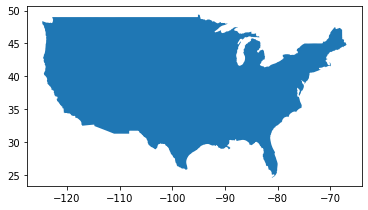

In [39]:

fo=gpd.read_file('/home/vikram/BCSD_Shapefiles/Us_boundary.shp')
fo.plot()

shp_geom = shape(fo.geometry[0])

xxc, yyc = np.meshgrid(lon_obs.data-360,lat_obs.data)
mask_shape=np.empty_like(xxc)

N1=xxc.shape[0]
N2=xxc.shape[1]
for lat_i in range(N1):
  for lon_i in range(N2):
    xi=xxc[lat_i,lon_i]
    yi=yyc[lat_i,lon_i]
    m1= (shp_geom.contains(Point(xi, yi)) or shp_geom.touches(Point(xi, yi)))
    mask_shape[lat_i,lon_i]=not m1


## Figure 5

In [25]:
def map_plot_cyl_final(data_lat_x_lon,lat_cen,lon_cen,map_bounds,clab,y_limit,ax,mp_spacing=10,subplot_iter=1,loff=1,coff=1,ex='both'):

  lat_box=uu.cen_to_box(lat_cen)
  lon_box=uu.cen_to_box(lon_cen)

  map = Basemap(projection='cyl',resolution='l',
                llcrnrlon=map_bounds[0], 
                urcrnrlat=map_bounds[1],
                urcrnrlon=map_bounds[2], 
                llcrnrlat=map_bounds[3])


  xx, yy = meshgrid(lon_box,lat_box )
  #return  dimenion of lat * lon
  map.pcolor(xx, yy, data_lat_x_lon,cmap='RdBu_r')
  map.drawmeridians(np.arange(-180,180,mp_spacing),labels=[0,0,0,1], linewidth=1.0) #longitudes
  if loff==0:
    map.drawparallels(np.arange(-90,90,mp_spacing),labels=[1,0,0,0], linewidth=1.0) #latitudes
  else:
    map.drawparallels(np.arange(-90,90,mp_spacing),labels=[0,0,0,0], linewidth=1.0) #latitudes
  cbar = map.colorbar(extend=ex)
  #cbar.ax.set_yticklabels(['0','1','2','>3'])
  cbar.set_label(clab, rotation=90)
  plt.clim(y_limit)

  if coff==1:
    cbar.remove()

  #map.drawcountries(linewidth=1)
  map.readshapefile('/home/vikram/BCSD_Shapefiles/Us_boundary','UU',linewidth=2.0)

  map.drawcoastlines(linewidth=1)
  lxx=0.02
  lyy=1.02
  lcol='k'
  lsize=24
  lfamily='Arial'
  lweight=800
 # y_limit=[0,30]
  #clab='days'
  
  plt.text(lxx, lyy, chr(subplot_iter+96), horizontalalignment='left',verticalalignment='bottom', transform=ax.transAxes,fontweight=lweight,
           fontfamily=lfamily,fontsize=lsize,color=lcol)

Text(0.08, 0.25, '$\\Delta$T|D1')

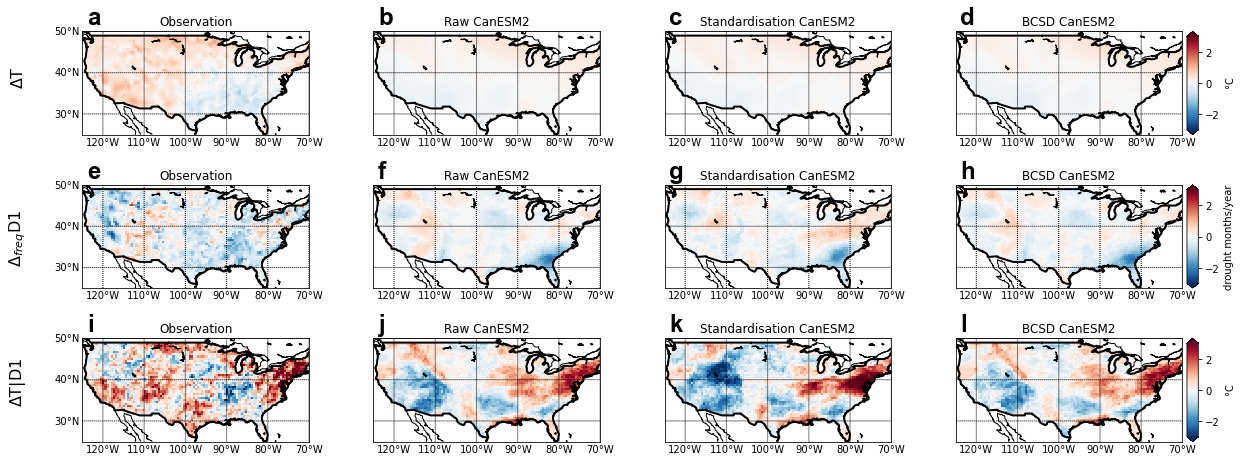

In [27]:
data_bounds=[ -125, 50, -70, 25]
gcm_iter=1
Dl=[0,1,2,3]
gcm_name=gcm_names[gcm_iter]
dapa=[delta_tas[0,:,:],
  delta_tas[1,:,:],
  delta_tas[1+9,:,:],
  delta_tas[1+18,:,:],
  delta_spi_freq_sp2[0,:,:],
  delta_spi_freq_sp2[1,:,:],
  delta_spi_freq_sp2[1+9,:,:],
  delta_spi_freq_sp2[1+18,:,:],
  delta_tas_d1[0,:,:],
  delta_tas_d1[1,:,:],
  delta_tas_d1[1+9,:,:],
  delta_tas_d1[1+18,:,:]]
y_limits=[[-1.5,1.5],
         [-1.5,1.5],
         [-1.5,1.5]]

y_limits=[[-3,3],
         [-3,3],
         [-3,3]]


lofff=[0,1,1,1,0,1,1,1,0,1,1,1]
cofff=[1,1,1,0,1,1,1,0,1,1,1,0]
titlesx=['Observation','Raw '+gcm_name,'Standardisation '+gcm_name,'BCSD '+gcm_name]
titlesy=['$\Delta$T','$\Delta_{freq}$D1','$\Delta$T|D1']
labels=['$\degree$C','drought months/year','$\degree$C']

ex='both'
fig=plt.figure(figsize=(20,8))

for rr in range(3):
  for cc in range(4):
    iter1=rr*4+cc
    iter2=rr*3+cc
    ax=plt.subplot(3,4,iter1+1)
    #plt.pcolor(ma.masked_array(dapa[rr*4+cc], mask=mask))
    map_plot_cyl_final(ma.masked_array(dapa[iter1], mask=mask_shape),
                       lat_obs,lon_obs-360,data_bounds,labels[rr],y_limits[rr],
                       ax,mp_spacing=10,subplot_iter=iter1+1,loff=lofff[iter1],
                       coff=cofff[iter1],ex=ex)
    plt.title(titlesx[cc])


fig.text(0.08, 0.78, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.5, titlesy[1], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.25, titlesy[2], va='center', ha='center', rotation='vertical', fontsize=16)
# plt.savefig('/home/vikram/Dropbox/BCSD Work/03_Figures/Figures/Figure5/with_std_extended_'+gcm_name+output_figname+'.svg')

In [112]:
def S_score_2D(data_ref, data_model,mask_inf):
    # mask is true for exterior values
    data_1 = data_ref
    data_2 = data_model 
    ind_1 = np.isnan(data_1)
    ind_2 = np.isnan(data_2)
    data_1[ind_2] = np.nan
    data_2[ind_1] = np.nan
    data_1[mask_inf == True] = np.nan
    data_2[mask_inf == True] = np.nan

    data_1 = data_1.flatten()
    data_2 = data_2.flatten()
    
    data_1 =  np.delete(data_1,np.isnan(data_1))
    data_2 =  np.delete(data_2,np.isnan(data_2))
    R = np.corrcoef(data_1,data_2)[0,1]

    SDR = np.std(data_2)/np.std(data_1)

    S_score = (1+R)**4  / ( 4 * (SDR + 1 / SDR)**2 )

    
    return S_score

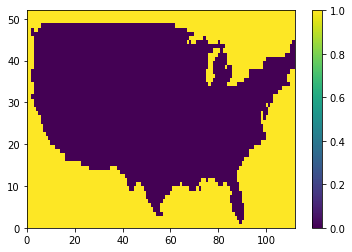

In [113]:
plt.pcolor(mask_shape)
plt.colorbar()

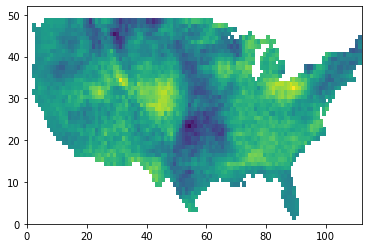

In [114]:
plt.pcolor(delta_tas_d1[1,:,:])

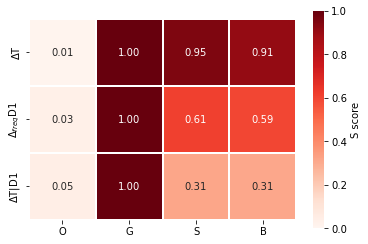

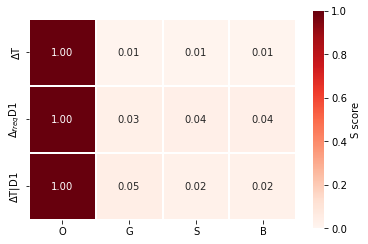

In [123]:
D=4
N_index= 3
S_score_matrix = np.zeros((N_index,D))
for itr,index in enumerate([delta_tas,delta_spi_freq_sp2,delta_tas_d1]):
    for di,d in enumerate([0,1,3,2]):
        S_score_matrix[itr,di] = (S_score_2D(index[1,:,:],index[d,:,:],mask_shape))
        
titlesy=['$\Delta$T','$\Delta_{freq}$D1','$\Delta$T|D1']
        
h=sns.heatmap(S_score_matrix , linewidth = 2 , cmap = 'Reds', 
          annot=True,
          fmt=".2f", square=True,
          xticklabels=['O','G','S','B'],
          yticklabels=titlesy,vmin=0,vmax=1,
             
          cbar_kws={'label': 'S score','extend':None},cbar = True)


plt.savefig('/home/vikram/Dropbox/BCSD Work/03_Figures/Figures/Figure5/with_std_Score_extended_wrt_gcm_'+gcm_name+output_figname+'.svg')


plt.figure()
D=4
N_index= 3
S_score_matrix = np.zeros((N_index,D))
for itr,index in enumerate([delta_tas,delta_spi_freq_sp2,delta_tas_d1]):
    for d in [0,1,3,2]:
        S_score_matrix[itr,d] = (S_score_2D(index[0,:,:],index[d,:,:],mask_shape))
        
titlesy=['$\Delta$T','$\Delta_{freq}$D1','$\Delta$T|D1']
        
h=sns.heatmap(S_score_matrix , linewidth = 2 , cmap = 'Reds', 
          annot=True,
          fmt=".2f", square=True,
          xticklabels=['O','G','S','B'],
          yticklabels=titlesy,vmin=0,vmax=1,
             
          cbar_kws={'label': 'S score','extend':None},cbar = True)


# plt.savefig('/home/vikram/Dropbox/BCSD Work/03_Figures/Figures/Figure5/Score_extended_wrt_obs_'+gcm_name+output_figname+'.svg')

# cbar_kws={'label': '°C','extend':'max'},cbar

In [116]:
path_out_P

'/home/vikram/BCSD_data/US_P_BCSD_eqm/'

## Other


In [28]:


def plot_hmap(data_corr,ylim,titles,fmt,cmap):
  fig=plt.figure(figsize=(14,8))
  S=data_corr[0].shape[0]
  for iii in range(3):
    for subs in range(S):
      ax=plt.subplot(3,4,iii*4+subs+1)
      
      data_set = data_corr[iii][subs,:,:]
      
      if (subs<S-1):
        cbarI=False
      else:
        cbarI=True

      h=sns.heatmap(data_set , linewidth = 2 , cmap = cmap, 
                  annot=True,
                  fmt=fmt ,square=True,
                  xticklabels=titles,
                  yticklabels=titles,vmin=ylim[iii][0],vmax=ylim[iii][1],
                    cbar_kws={'label': '°C','extend':'max'},cbar=cbarI)
      if iii==0:
        plt.title(region_shapes['NAME'][subs])
        
      lxx=-0.20
      lyy=0.8
      lcol='k'
      lsize=24
      lfamily='Tahoma'
      lweight=800
      
      plt.text(lxx, lyy,  chr(iii*4+subs+1+96), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=lweight,
              fontsize=lsize,color=lcol)    

  fig.text(0.08, 0.78, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
  fig.text(0.08, 0.5, titlesy[1], va='center', ha='center', rotation='vertical', fontsize=16)
  fig.text(0.08, 0.25, titlesy[2], va='center', ha='center', rotation='vertical', fontsize=16)
  fig.suptitle(gcm_name)
  plt.savefig('/home/vikram/Dropbox/BCSD Work/03_Figures/Figures/Figure5/extended_rmse_'+gcm_name+'.svg')
  plt.show()

In [64]:
titles=['Obs','GCM','BC-G','BC-R']


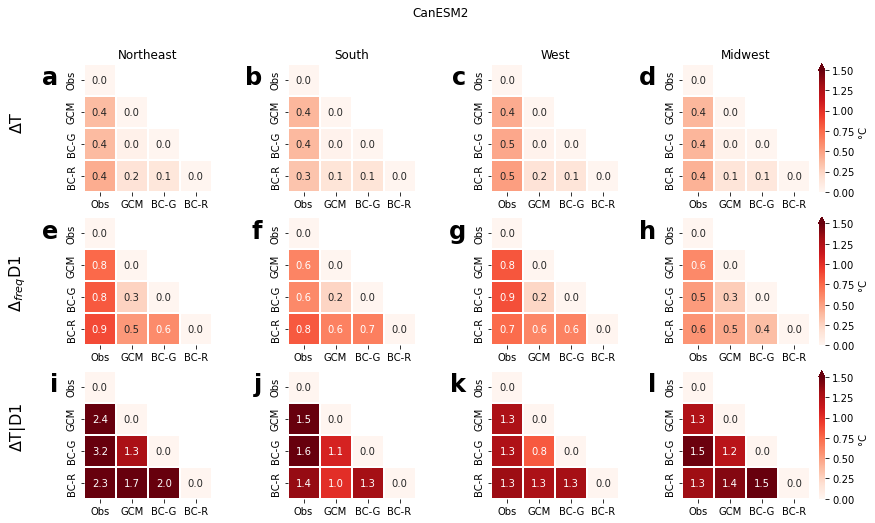

In [65]:
plot_hmap([ind1h,ind2h,ind3h],[[0,1.5],[0,1.5],[0,1.5]],titles,".1f",'Reds')

### RMSE SHort

In [67]:


def plot_hmap_short(data_corr,ylim,titles,fmt,cmap):
  titlesy=['$\Delta$T','$\Delta_{freq}$D1','$\Delta$T|D1']
  fig=plt.figure(figsize=(12,2))
  S=data_corr[0].shape[0]
  for iii in range(3):
      ax=plt.subplot(1,3,iii+1)
      
      data_set=np.zeros((4,3))
      for subs in range(S):
        data_set[subs,:]= data_corr[iii][subs,1:,0]

      h=sns.heatmap(data_set.T , linewidth = 2 , cmap = cmap, 
                  annot=True,
                  fmt=fmt ,square=True,
                  xticklabels=titles[0],
                  yticklabels=titles[1],vmin=ylim[iii][0],vmax=ylim[iii][1],
                  cbar_kws={'label': labels[iii],'extend':'max'})
        
      lxx=0
      lyy=1
      lcol='k'
      lsize=24
      lfamily='Tahoma'
      lweight=800
      
      plt.text(lxx, lyy,  chr(iii+1+96), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=lweight,
              fontsize=lsize,color=lcol)    
      plt.title(titlesy[iii])

  fig.text(0.5, -0.1, gcm_name, va='center', ha='center', fontsize=16)
  plt.savefig('/home/vikram/Dropbox/BCSD Work/03_Figures/Figures/Figure5/extended_rmse_ss'+gcm_name+'.svg')
  plt.show()

In [68]:
titlesy=['GCM','BC-G','BC-R']
titlesx=['N','S','W','MW']
labels=['$\degree$C','drought months/year','$\degree$C']
titles=[titlesx,titlesy]

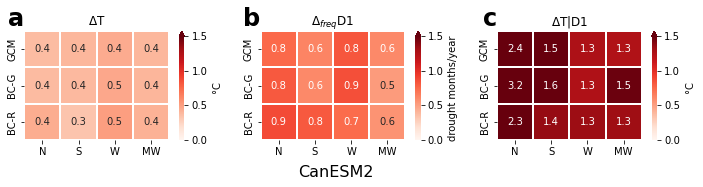

In [69]:
plot_hmap_short([ind1h,ind2h,ind3h],[[0,1.5],[0,1.5],[0,1.5]],titles,".1f",'Reds')

## Final short

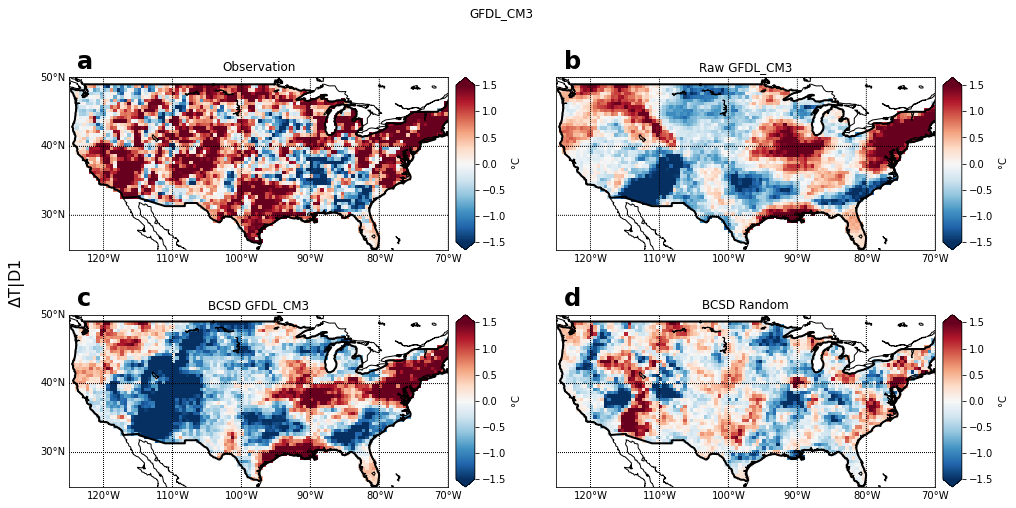

In [ ]:
gcm_iter=3
Dl=[0,1+gcm_iter,5+gcm_iter,9+gcm_iter]
gcm_name=gcm_names[gcm_iter]
dapa=[delta_tas_d1[Dl[0],:,:],
  delta_tas_d1[Dl[1],:,:],
  delta_tas_d1[Dl[2],:,:],
  delta_tas_d1[Dl[3],:,:]]

y_limit=[-1.5,1.5]
labels=['$\degree$C']
lofff=[0,1,0,1]
cofff=[0,0,0,0]
titlesx=['Observation','Raw '+gcm_name,'BCSD '+gcm_name,'BCSD Random']
titlesy=['$\Delta$T|D1']
ex='both'
fig=plt.figure(figsize=(16,8))

for rr in range(2):
  for cc in range(2):
    iter=rr*2+cc
    ax=plt.subplot(2,2,iter+1)
    #plt.pcolor(ma.masked_array(dapa[rr*4+cc], mask=mask))
    map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask_shape),lat_obs,lon_obs-360,data_bounds,labels[0],y_limits[0],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    plt.title(titlesx[iter])


fig.text(0.08, 0.5, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
fig.suptitle(gcm_name)
plt.savefig('/content/drive/MyDrive/Figures/Figure5/brief_'+gcm_name+'.svg')

In [ ]:
data_bounds=[ 360-125, 50, 360-70, 25]

lab_list=['Obs','GCM0*','GCM1*','GCM2*','GCM3*','BCSD-GCM0','BCSD-GCM1','BCSD-GCM2','BCSD-GCM3','BCSD-RND0','BCSD-RND1','BCSD-RND2','BCSD-RND3']
lweight=500
lsize=20
lcol='k'
sx=1
sy=3
fig=plt.figure(figsize=(25,60))
ylim=[250,330]
for ii in range(sx):
  ind=ii*3
  ax=plt.subplot(sx,sy,ii*3+1)
  map_plot_cyl_change(delta_tas[ii],lat_obs,lon_obs,data_bounds,'',ylim,ax,mp_spacing=10,subplot_iter=ii+1,loff=(ind+1)%3,coff=(ind+1)%3)
  plt.title(lab_list[ii]+': $\Delta$T',fontweight=lweight,fontsize=lsize,color=lcol)

  ind=ii*3+1
  ax=plt.subplot(sx,sy,ii*3+1+1) 
  tt0=tas_period_0[ii,:,:,:]

  map_plot_cyl_change(tt0[0,:,:],lat_obs,lon_obs,data_bounds,'',ylim,ax,mp_spacing=10,subplot_iter=ii+1,loff=(ind+1)%3,coff=(ind+1)%3)
  plt.title(lab_list[ii]+': $\Delta$T|D0',fontweight=lweight,fontsize=lsize,color=lcol)
  ind=ii*3+1
  tt1=tas_period_1[ii,:,:,:]
  ax=plt.subplot(sx,sy,ii*3+2+1)
  map_plot_cyl_change(np.nanmean(tt1,axis=0),lat_obs,lon_obs,data_bounds,'',ylim,ax,mp_spacing=10,subplot_iter=ii+1,loff=(ind+1)%3,coff=(ind+1)%3)
  plt.title(lab_list[ii]+': $\Delta$T|D1',fontweight=lweight,fontsize=lsize,color=lcol)

plt.suptitle("Change in Annual Mean: (1902-1951) to (1955-2005)",fontsize=24,color='k')



In [ ]:
data_bounds=[ 360-125, 50, 360-70, 25]

lab_list=['Obs','GCM0*','GCM1*','GCM2*','GCM3*','BCSD-GCM0','BCSD-GCM1','BCSD-GCM2','BCSD-GCM3','BCSD-RND0','BCSD-RND1','BCSD-RND2','BCSD-RND3']
lweight=500
lsize=20
lcol='k'
sx=13
sy=3
fig=plt.figure(figsize=(25,60))
ylim=[250,330]
for ii in range(sx):
  ind=ii*3
  ax=plt.subplot(sx,sy,ii*3+1)
  map_plot_cyl_change(delta_tas[ii],lat_obs,lon_obs,data_bounds,'',ylim,ax,mp_spacing=10,subplot_iter=ind+1,loff=(ind+1)%3,coff=(ind+1)%3)
  plt.title(lab_list[ii]+': $\Delta$T',fontweight=lweight,fontsize=lsize,color=lcol)

  ind=ii*3+1
  ax=plt.subplot(sx,sy,ii*3+1+1) 
  tt0=spi_period_0[ii,:,:,:]

  map_plot_cyl_change(tt0[0,:,:],lat_obs,lon_obs,data_bounds,'',ylim,ax,mp_spacing=10,subplot_iter=ind+1,loff=(ind+1)%3,coff=(ind+1)%3)
  plt.title(lab_list[ii]+': $\Delta$T|D0',fontweight=lweight,fontsize=lsize,color=lcol)
  ind=ii*3+2
  tt1=spi_period_1[ii,:,:,:]
  ax=plt.subplot(sx,sy,ii*3+2+1)
  map_plot_cyl_change(np.nanmean(tt1,axis=0),lat_obs,lon_obs,data_bounds,'',ylim,ax,mp_spacing=10,subplot_iter=ind+1,loff=(ind+1)%3,coff=(ind+1)%3)
  plt.title(lab_list[ii]+': $\Delta$T|D1',fontweight=lweight,fontsize=lsize,color=lcol)

plt.suptitle("Change in Annual Mean: (1902-1951) to (1955-2005)",fontsize=24,color='k')

